In [1]:
# first we get the measured mass function
# then we use central differences to compute $d^2 \ln N / d \ln M^2$
# from there we plug into mass calibiration formula

In [2]:
from utils import *
from massfunction import *

import numpy as np
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import os
import emcee
import sys
import numpy as np
import pickle

In [3]:
cosmos_f = open('data/cosmo_params.pkl', 'rb')
cosmo_params = pickle.load(cosmos_f) #cosmo_params is a dict
cosmos_f.close()

In [4]:
a_list_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/alist.pkl'
a_list_f = open(a_list_fname, 'rb')
a_list = pickle.load(a_list_f) 
a_list_f.close()

###TEMP
# a_list = [a_list[0], a_list[1]]
#######
print('alist', a_list)

alist [1.0, 0.953321, 0.866399, 0.787402, 0.715608, 0.65036, 0.620002, 0.591061, 0.563471, 0.537169, 0.512095, 0.488191, 0.403224, 0.366459]


In [5]:
weird_boxes = ['Box63_1400', 'Box35_1400', 'Box_n50_38_1400', 'Box5_1400']
measured_N = {box:{a:{} for a in a_list} for box in cosmo_params if box not in weird_boxes} 


for box in tqdm(cosmo_params):
    if(box in weird_boxes):
        continue
#     if('n50' in box and eval(box.split('_')[-2])>=42):
#         print('skippinig', box)
#         continue
#     if('n50' in box or eval(box.split('_')[0][3:]) >= 73):
#         print('ski', box)
    for a in a_list:
        plot_data = None
        try:
            with open("/scratch/users/delon/aemulusnu_massfunction/%s_%.2f_NvMemulator_loo_output.pkl"%(box, a), "rb") as f:
                plot_data = pickle.load(f)
        except:
            print('skipiping', box)
            continue
        model = plot_data['tinker_eval']
        true  = plot_data['N']
        edges = plot_data['edges']
        measured_N[box][a] = [true, edges]

100%|██████████| 150/150 [00:02<00:00, 62.42it/s]


In [186]:
print(a_list)

[1.0, 0.953321, 0.866399, 0.787402, 0.715608, 0.65036, 0.620002, 0.591061, 0.563471, 0.537169, 0.512095, 0.488191, 0.403224, 0.366459]


0.26999931420037027
[12.9 13.  13.1 13.2 13.3 13.4 13.5 13.6 13.7 13.8 13.9 14.  14.1 14.2
 14.3 14.4 14.5 14.6 14.7 14.8 14.9 15.  15.1 15.5]
[12.9 13.  13.1 13.2 13.3 13.4 13.5 13.6 13.7 13.8 13.9 14.  14.1 14.2
 14.3 14.4 14.5 14.6 14.7 14.8 14.9 15.  15.1]
[0.23025851 0.23025851 0.23025851 0.23025851 0.23025851 0.23025851
 0.23025851 0.23025851 0.23025851 0.23025851 0.23025851 0.23025851
 0.23025851 0.23025851 0.23025851 0.23025851 0.23025851 0.23025851
 0.23025851 0.23025851 0.23025851 0.23025851]
[         nan  -0.42708586  -0.23426354   0.32011439  -0.34910446
  -0.17163128  -0.36619219   0.18371166  -0.33861128  -0.57409372
  -1.15582842   0.97488416  -0.34215955  -1.12357717  -0.78598841
  -0.18614609  -2.04475692   0.07960168  -1.10605775  -0.32885553
 -10.87685811          nan]


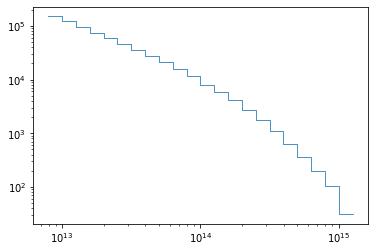

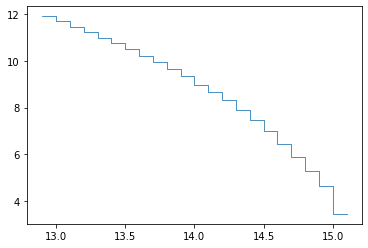

In [318]:
curr_box = 'Box_n50_0_1400'
curr_a = a_list[3]
curr_z = scaleToRedshift(curr_a)
print(curr_z)

curr_N, curr_edges = measured_N[curr_box][curr_a]

print(np.log10(curr_edges))
curr_N = curr_N[:-1]
curr_edges = curr_edges[:-1]
print(np.log10(curr_edges))

curr_logedges = np.log(curr_edges)
print(np.diff(curr_logedges))
curr_log10edges =  np.log10(curr_edges)

curr_logN = np.log(curr_N)

fig, ax = plt.subplots(nrows=1, ncols=1)
plt.xscale('log')
plt.yscale('log')
ax.step(curr_edges, curr_N+[curr_N[-1]], where='post', linewidth=0.8)

fig, ax = plt.subplots(nrows=1, ncols=1)
ax.step(curr_log10edges, np.append(curr_logN,[curr_logN[-1]]), where='post', linewidth=0.8)

# Convert edges to bin centers
bin_centers = (curr_logedges[1:] + curr_logedges[:-1]) / 2

# Compute the width of a bin
delta_logM = curr_logedges[1] - curr_logedges[0]
# print(delta_logM)


####TEST
# X = np.linspace(0,10,1000)
# curr_logN = np.array(list(map(lambda x:np.sin(x), X)))
# delta_logM = X[1]-X[0]
# ########


# Compute first derivative using central differences
first_derivative = (curr_logN[2:] - curr_logN[:-2]) / (2 * delta_logM)

# Compute second derivative using central differences
second_derivative = (curr_logN[2:] - 2 * curr_logN[1:-1] + curr_logN[:-2]) / (delta_logM**2)

# The second_derivative array is shorter than the original bins array by 2
# If we want them to be the same size, we can add np.nan to both ends
second_derivative = np.concatenate([[np.nan], second_derivative, [np.nan]])
print(second_derivative)

###TEST
# plt.show()
# plt.plot(X, -curr_logN)
# plt.scatter(X, second_derivative, s=1, marker='x', color='red')
#######

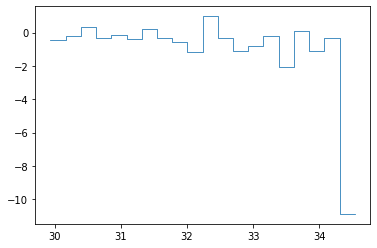

In [319]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.step(curr_logedges, np.append(second_derivative,[second_derivative[-1]]), where='post', linewidth=0.8)

In [291]:
with open("/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/%s_%.2f_params.pkl"%(curr_box, curr_a), "rb") as f:
    MLE_params = pickle.load(f)
print(MLE_params)

NvM_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/'+curr_box+'_NvsM.pkl'
NvM_f = open(NvM_fname, 'rb')
NvMs = pickle.load(NvM_f) #NvMs is a dictionary of dictionaries
NvM_f.close()
c_data = NvMs[curr_a]
vol = c_data['vol']

mass_function = MassFunction(cosmo_params[curr_box])
mass_function.compute_dlnsinvdM(curr_a)
param_names = ['d','e','f','g']
c_params = MLE_params
M_numerics = np.logspace(12, 17, 50)

tinker_eval = [mass_function.tinker(a, M_c, **c_params,)*vol for M_c in M_numerics]
# f_dlogNdlogM =  interp1d(np.log(M_numerics), np.log(tinker_eval), kind='linear', 
#                         bounds_error=False, fill_value=0.)

from scipy.interpolate import UnivariateSpline

# Fit spline to data
spline = UnivariateSpline(np.log(M_numerics), np.log(tinker_eval), k=3, s=0)

# Define second derivative function
def fd2logNdlogM22(x):
    return spline.derivative(n=1)(x)

# Now second_derivative is a function you can call with a value for 'x' to get the second derivative at that point.

{'d': 0.5001480285857915, 'e': 1.1851140200996846, 'f': 2.332368872235302, 'g': 1.2856144862094576}


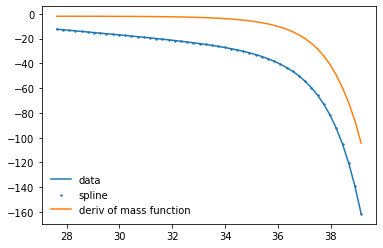

In [320]:
plt.plot(np.log(M_numerics), np.log(tinker_eval), label='data')
plt.scatter(np.log(M_numerics), np.array(list(map(spline, np.log(M_numerics)))), label='spline', s=2)
plt.plot(np.log(M_numerics), np.array(list(map(fd2logNdlogM22, np.log(M_numerics)))), label='deriv of mass function')

plt.legend(frameon=False)

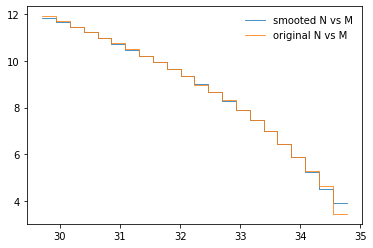

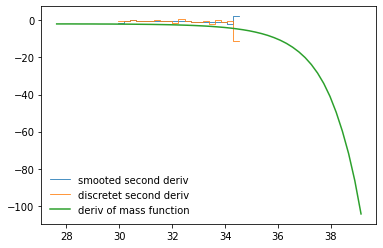

In [323]:
from scipy.ndimage import gaussian_filter1d

# Set the standard deviation for Gaussian smoothing
sigma = 1

# Apply Gaussian smoothing
smooth_logN = gaussian_filter1d(curr_logN, sigma)

fig, ax = plt.subplots(nrows=1, ncols=1)
ax.step(curr_logedges, np.append(smooth_logN, [smooth_logN[-1]]), where='post', linewidth=0.8, label='smooted N vs M')
ax.step(curr_logedges, np.append(curr_logN,[curr_logN[-1]]), where='post', linewidth=0.8, label='original N vs M')
plt.legend(frameon=False)

# Compute first derivative using central differences on the smoothed data
smooth_first_derivative = (smooth_logN[2:] - smooth_logN[:-2]) / (2 * delta_logM)

# Compute second derivative using central differences on the smoothed data
smooth_second_derivative = (smooth_logN[2:] - 2 * smooth_logN[1:-1] + smooth_logN[:-2]) / (delta_logM**2)

# The second_derivative array is shorter than the original bins array by 2
# If we want them to be the same size, we can add np.nan to both ends
smooth_second_derivative = np.concatenate([[np.nan], smooth_second_derivative, [np.nan]])

fig, ax = plt.subplots(nrows=1, ncols=1)
ax.step(curr_logedges, np.append(smooth_second_derivative, [smooth_second_derivative[-1]]), where='post', linewidth=0.8, label='smooted second deriv')
ax.step(curr_logedges, np.append(second_derivative,[second_derivative[-1]]), where='post', linewidth=0.8, label='discretet second deriv')

# plt.plot(np.log(M_numerics), np.log(tinker_eval), label='data')
# plt.scatter(np.log(M_numerics), np.array(list(map(spline, np.log(M_numerics)))), label='spline', s=2)
plt.plot(np.log(M_numerics), np.array(list(map(fd2logNdlogM22, np.log(M_numerics)))), label='deriv of mass function')


plt.legend(frameon=False)



In [324]:
# now lets compute $\sigma^2_{\ln N} 
curr_Mcenters = [np.exp(bin_center) for bin_center in bin_centers]

A = 0.7*10**(22)
n0 = 6.3
zs = 0.5

curr_mass_calibration_uncertainty = []


SNs = []
SVs = []
for i in range(len(bin_centers)):
    ΔlogM = delta_logM
    print(ΔlogM, 0.1 * np.log(10))
    NinBin = curr_N[i]
    Mcenter = curr_Mcenters[i]
    α = fd2logNdlogM22(Mcenter)

    print(Mcenter)
    SV = (0.4)**2/NinBin 
    SN = 1/(Mcenter)**2 * (A*Mcenter**(1/2))/NinBin * 6.3/n0 * np.exp(-1/2 * curr_z**2/ zs**2)
    print(SV, SN)
    SNs += [SN]
    SVs += [SV]
    mass_calibration_uncertainty_in_bin = (α * ΔlogM)**2 * (SV + SN)
    print(mass_calibration_uncertainty_in_bin)
    curr_mass_calibration_uncertainty += [0.1*(mass_calibration_uncertainty_in_bin)]

0.2302585092994036 0.2302585092994046
8912509381337.46
1.0655726787165179e-06 0.001514402508105134
4.435599466736805e+50
0.2302585092994036 0.2302585092994046
11220184543019.63
1.3156812762108382e-06 0.0013237590363561912
9.741950011480783e+50
0.2302585092994036 0.2302585092994046
14125375446227.525
1.6616988793918186e-06 0.001183615300327899
2.1888973014479928e+51
0.2302585092994036 0.2302585092994046
17782794100389.188
2.1249468763280923e-06 0.0010715349002446712
4.980491928814874e+51
0.2302585092994036 0.2302585092994046
22387211385683.324
2.6716091435822943e-06 0.0009537425635563269
1.1144267604518144e+52
0.2302585092994036 0.2302585092994046
28183829312644.42
3.4216547978015875e-06 0.0008647576966792799
2.541060361031372e+52
0.2302585092994036 0.2302585092994046
35481338923357.37
4.422332780541737e-06 0.0007912426042568657
5.849729029942796e+52
0.2302585092994036 0.2302585092994046
44668359215096.04
5.827718084137681e-06 0.0007381706580154984
1.3739708429567209e+53
0.2302585092994

In [328]:
# now lets compute $\sigma^2_{\ln N} 
curr_Mcenters = [np.exp(bin_center) for bin_center in bin_centers]

A = 0.7*10**(22)

n0 = {'DES Y1': 6.3, 'DES Y5':8.4, 'LSST Y1':10}
zs = {'DES Y1': 0.5, 'DES Y5':0.6, 'LSST Y1':0.85}

curr_mass_calibration_uncertainty = {'DES Y1': [], 'DES Y5': [], 'LSST Y1': []}


SNs = []
SVs = []
for key in curr_mass_calibration_uncertainty:
    for i in range(len(bin_centers)):

        ΔlogM = delta_logM
#         print(ΔlogM, 0.1 * np.log(10))
        NinBin = curr_N[i]
        Mcenter = curr_Mcenters[i]
        α = fd2logNdlogM22(np.log(Mcenter))

#         print(np.log10(Mcenter))
#         print(Mcenter)
        SV = (0.4)**2/NinBin 
        SN = 1/(Mcenter)**2 * (A*Mcenter**(1/2))/NinBin * 6.3/n0[key] * np.exp(-1/2 * curr_z**2/ zs[key]**2)
#         print(SV, SN)
        if(key == 'DES Y1'):
            SNs += [SN]
            SVs += [SV]
        mass_calibration_uncertainty_in_bin = (α * ΔlogM)**2 * (SV + SN)
#         print(mass_calibration_uncertainty_in_bin)
        curr_mass_calibration_uncertainty[key] += [0.1*(mass_calibration_uncertainty_in_bin)]

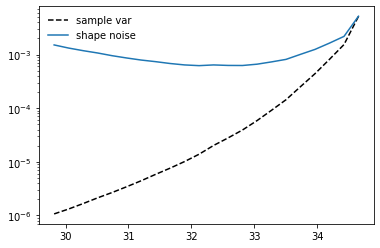

In [329]:
plt.plot(bin_centers, SVs, 'k--', label='sample var')
plt.plot(bin_centers, SNs, label='shape noise')

plt.yscale('log')
plt.legend(frameon=False)

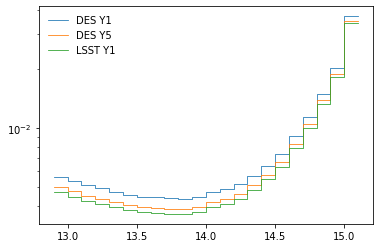

In [330]:
fig, ax = plt.subplots(nrows=1, ncols=1)
for key in curr_mass_calibration_uncertainty:
    ax.step(curr_log10edges, np.sqrt(np.append(curr_mass_calibration_uncertainty[key], [curr_mass_calibration_uncertainty[key][-1]])), where='post', linewidth=0.8, label=key)
plt.yscale('log')
plt.legend(frameon=False)

In [337]:
curr_box = 'Box_n50_0_1400'
curr_a = a_list[3]

def get_accuracy_requirement(curr_box, curr_a):
    
    
    
    with open("/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/%s_%.2f_params.pkl"%(curr_box, curr_a), "rb") as f:
        MLE_params = pickle.load(f)

    NvM_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/'+curr_box+'_NvsM.pkl'
    NvM_f = open(NvM_fname, 'rb')
    NvMs = pickle.load(NvM_f) #NvMs is a dictionary of dictionaries
    NvM_f.close()
    c_data = NvMs[curr_a]
    vol = c_data['vol']

    mass_function = MassFunction(cosmo_params[curr_box])
    with open("/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/%s_massfunction.pkl"%(curr_box), "rb") as f:
        tmp = pickle.load(f)
        mass_function.dlnσinvdMs = tmp[0]
        mass_function.Pka = tmp[1]

#     mass_function.compute_dlnsinvdM(curr_a)
    param_names = ['d','e','f','g']
    c_params = MLE_params
    M_numerics = np.logspace(12, 17, 50)

    tinker_eval = [mass_function.tinker(a, M_c, **c_params,)*vol for M_c in M_numerics]
    # f_dlogNdlogM =  interp1d(np.log(M_numerics), np.log(tinker_eval), kind='linear', 
    #                         bounds_error=False, fill_value=0.)

    from scipy.interpolate import UnivariateSpline

    # Fit spline to data
    spline = UnivariateSpline(np.log(M_numerics), np.log(tinker_eval), k=3, s=0)

    # Define second derivative function
    def fd2logNdlogM2(x):
        return spline.derivative(n=1)(x)

    
    curr_z = scaleToRedshift(curr_a)

    curr_N, curr_edges = measured_N[curr_box][curr_a]

    curr_N = curr_N[:-1]
    curr_edges = curr_edges[:-1]

    curr_logedges = np.log(curr_edges)
    curr_logN = np.log(curr_N)

    # Convert edges to bin centers
    bin_centers = (curr_logedges[1:] + curr_logedges[:-1]) / 2

    # Compute the width of a bin
    delta_logM = curr_logedges[1] - curr_logedges[0]

    # Compute first derivative using central differences
    first_derivative = (curr_logN[2:] - curr_logN[:-2]) / (2 * delta_logM)

    # Compute second derivative using central differences
    second_derivative = (curr_logN[2:] - 2 * curr_logN[1:-1] + curr_logN[:-2]) / (delta_logM**2)

    # The second_derivative array is shorter than the original bins array by 2
    # If we want them to be the same size, we can add np.nan to both ends
    second_derivative = np.concatenate([[np.nan], second_derivative, [np.nan]])

    # now lets compute $\sigma^2_{\ln N} 
    curr_Mcenters = [np.exp(bin_center) for bin_center in bin_centers]

    A = 0.7e22

    n0 = {'DES Y1': 6.3, 'DES Y5':8.4, 'LSST Y1':10}
    zs = {'DES Y1': 0.5, 'DES Y5':0.6, 'LSST Y1':0.85}

    curr_mass_calibration_uncertainty = {'DES Y1': [], 'DES Y5': [], 'LSST Y1': []}


    SNs = []
    SVs = []
    for key in curr_mass_calibration_uncertainty:
        for i in range(len(bin_centers)):
            ΔlogM = delta_logM
            NinBin = curr_N[i]
            Mcenter = curr_Mcenters[i]
            α = fd2logNdlogM2(np.log(Mcenter))

            SV = (0.4)**2/NinBin 
            SN = 1/(Mcenter)**2 * (A*Mcenter**(1/2))/NinBin * 6.3/n0[key] * np.exp(-1/2 * curr_z**2/ zs[key]**2)
            mass_calibration_uncertainty_in_bin = (α * ΔlogM)**2 * (SV + SN)
            curr_mass_calibration_uncertainty[key] += [np.sqrt(0.1*(mass_calibration_uncertainty_in_bin))]
    return curr_mass_calibration_uncertainty

In [338]:
accuracy_requirements = {'DES Y1':{a:{} for a in a_list}, 'DES Y5':{a:{} for a in a_list}, 'LSST Y1':{a:{} for a in a_list}}


# for curr_box in ['Box_n50_0_1400']:
for curr_box in tqdm(cosmo_params):
    if(curr_box in weird_boxes):
        continue
    curr_N, curr_edges = measured_N[curr_box][a_list[3]]
    curr_accuracy_requirement = get_accuracy_requirement(curr_box, a_list[3])
    for key in curr_accuracy_requirement:
        for ledge, redge, required_accuracy in zip(np.log10(curr_edges), np.log10(curr_edges[1:]), curr_accuracy_requirement[key]):
            ledge = np.round(ledge, decimals=1)
            redge = np.round(redge, decimals=1)
            if((ledge, redge) not in accuracy_requirements[key][a]):
                accuracy_requirements[key][a][(ledge, redge)] = []
            if(not np.isnan(required_accuracy)):
                accuracy_requirements[key][a][(ledge, redge)] += [required_accuracy]


100%|██████████| 150/150 [17:07<00:00,  6.85s/it]


[0.013488892711057255, 0.009281708442908172, 0.007930709634298178, 0.006119803819812245, 0.005685285520455738, 0.005248695514549775, 0.005001412272360825, 0.004865838516471797, 0.004684719940532184, 0.004612435036131651, 0.0046000159688666725, 0.004622063923121291, 0.004611354140807381, 0.0047330817919803096, 0.00486392505029645, 0.005162494277169961, 0.005488068320858621, 0.0061331520938161495, 0.0068769134860301746, 0.007833838276537372, 0.00935936652571704, 0.01138238538473794, 0.014518748987340006, 0.018472923190800076, 0.021481822917031313, 0.01907896593427441, 0.0204657274105798, 0.020122722315594883, 0.025275096030636466]

[0.01194526281720265, 0.008219652978454412, 0.007023382099486603, 0.005419809382949898, 0.0050351928355353405, 0.004648786975912172, 0.00443011912016683, 0.004310514105875815, 0.0041507210791579, 0.004087583974878479, 0.00407785220035491, 0.004099195161801565, 0.004092209498417479, 0.004203833693375944, 0.0043251880742885135, 0.004598222047408233, 0.0048991702

/tmp/ipykernel_4164/1235821153.py:26: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim([0,0.199])


(0.001, 1.0)

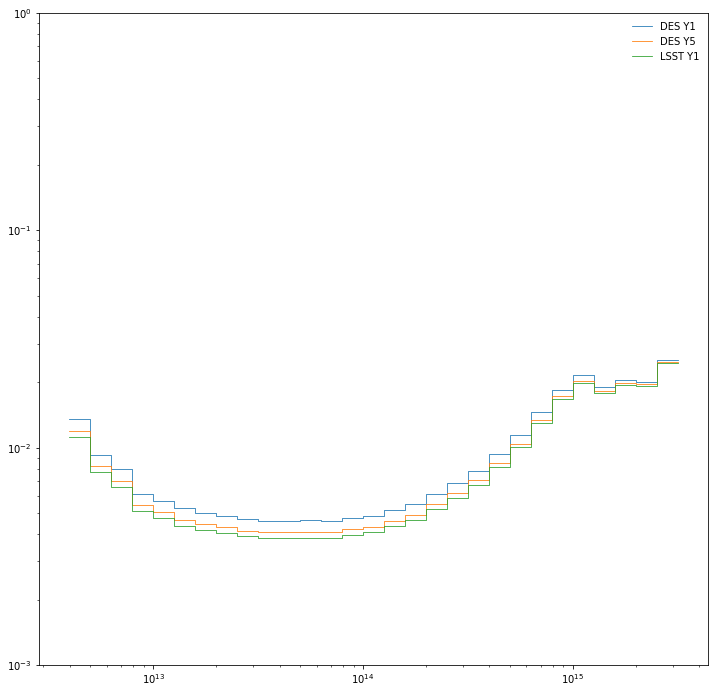

In [339]:
a = a_list[3]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,12))

for key in accuracy_requirements:
    curr_bin_accuracy_req = []
    edges = []
    for bins in sorted(accuracy_requirements[key][a]):
        if(bins[1]-bins[0] > 0.15): #ignore adaptive bins
            continue
        if(bins[0] not in edges):
            edges+=[(bins[0])]
        if(bins[1] not in edges):
            edges+=[(bins[1])]
        curr_bin_accuracy_req += [np.median(accuracy_requirements[key][a][bins])]
    print(curr_bin_accuracy_req)
    print()
    edge_centers = [1/2*(a+b) for a,b in zip(edges, edges[1:])]

    edges = 10**np.array(edges)
    edge_centers = 10**np.array(edge_centers)

    ax.step(edges, curr_bin_accuracy_req+[curr_bin_accuracy_req[-1]], where='post', label=key,linewidth=0.8)
    ax.set_yticks([ -0.1,0, 0.1,])
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim([0,0.199])
plt.legend(frameon=False)
plt.ylim([1e-3,1e0])